In [1]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import os
from os import path

In [2]:
semester = 'S19'
BASE_PATH = os.path.join('data', 'Release', semester)
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
TEST_PATH = os.path.join(BASE_PATH, 'Test')

In [3]:
train_ps2 = ProgSnap2Dataset(os.path.join(TRAIN_PATH, 'Data')) 

In [4]:
# The early dataset will help us to feature extraction,
# but we're not actually predicting anything here
# Note: we could still use this for model training if desired.
early_train = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early_train.head()

,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,Label
0,04c32d4d95425f73b3a1d6502aed4d48,439.0,1,1,True,True
1,04c32d4d95425f73b3a1d6502aed4d48,439.0,3,2,True,True
2,04c32d4d95425f73b3a1d6502aed4d48,439.0,5,3,True,True
3,04c32d4d95425f73b3a1d6502aed4d48,439.0,12,1,True,True
4,04c32d4d95425f73b3a1d6502aed4d48,439.0,13,2,True,True


In [5]:
# The late dataset contains the problems that we're actually predicting for.
# The training portion of it includes labels.
late_train = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))
late_train.head()

,SubjectID,AssignmentID,ProblemID,Label
0,04c32d4d95425f73b3a1d6502aed4d48,494.0,41,False
1,04c32d4d95425f73b3a1d6502aed4d48,494.0,43,True
2,04c32d4d95425f73b3a1d6502aed4d48,494.0,44,True
3,04c32d4d95425f73b3a1d6502aed4d48,494.0,46,True
4,04c32d4d95425f73b3a1d6502aed4d48,494.0,49,True


In [6]:
X_train_base = late_train.copy().drop('Label', axis=1)
y_train = late_train['Label'].values

In [7]:
problem_encoder = OneHotEncoder().fit(X_train_base[PS2.ProblemID].values.reshape(-1, 1))

In [8]:
problem_encoder.transform(X_train_base[PS2.ProblemID].values.reshape(-1, 1)).toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Task 1

In this task, we do per-problem prediction, extracting features from performance on the 30 early problems for a given student to predict performance on each of 20 later problems. Our model should, in effect, learn the releationship between the knowledge practiced in these problems (though our naive example here won't get that far).

In [9]:
def extract_instance_features(instance, early_df):
    instance = instance.copy()
    subject_id = instance[PS2.SubjectID]
    early_problems = early_df[early_df[PS2.SubjectID] == subject_id]
    # Extract very naive features about the student
    # (without respect to the problem bring predicted)
    # Number of early problems attempted
    instance['ProblemsAttempted'] = early_problems.shape[0]
    # Percentage of early problems gotten correct eventually
    instance['PercCorrectEventually'] = np.mean(early_problems['CorrectEventually'])
    # Median attempts made on early problems
    instance['MedAttempts'] = np.median(early_problems['Attempts'])
    # Max attempts made on early problems
    instance['MaxAttempts'] = np.max(early_problems['Attempts'])
    # Percentage of problems gotten correct on the first try
    instance['PercCorrectFirstTry'] = np.mean(early_problems['Attempts'] == 1)
    instance = instance.drop('SubjectID')
    return instance

In [10]:
extract_instance_features(X_train_base.iloc[0], early_train)

AssignmentID                  494
ProblemID                      41
ProblemsAttempted              30
PercCorrectEventually           1
MedAttempts                   6.5
MaxAttempts                    45
PercCorrectFirstTry      0.166667
Name: 0, dtype: object

In [11]:
def extract_features(X, early_df, scaler, is_train):
    # First extract performance features for each row
    features = X.apply(lambda instance: extract_instance_features(instance, early_df), axis=1)
    # Then one-hot encode the problem_id and append it
    problem_ids = problem_encoder.transform(features[PS2.ProblemID].values.reshape(-1, 1)).toarray()
    # Then get rid of nominal features
    features.drop([PS2.AssignmentID, PS2.ProblemID], axis=1, inplace=True)
    # Then scale the continuous features, fitting the scaler if this is training
    if is_train:
        scaler.fit(features)
    features = scaler.transform(features)
    
    # Return continuous and one-hot features together
    return np.concatenate([features, problem_ids], axis=1)

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = extract_features(X_train_base, early_train, scaler, True)

In [13]:
print(X_train.shape)
X_train[:2,]

(4201, 25)


array([[ 0.51751812,  0.58371895,  1.76922077,  1.70602676, -0.89569333,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.51751812,  0.58371895,  1.76922077,  1.70602676, -0.89569333,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

## Evaluate the Training Performance of the Model

In [14]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV()
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

print(classification_report(y_train, train_predictions))
print('AUC: ' + str(roc_auc_score(y_train, train_predictions)))
print('Macro F1: ' + str(f1_score(y_train, train_predictions, average='macro')))

              precision    recall  f1-score   support

       False       0.59      0.27      0.37      1084
        True       0.79      0.93      0.85      3117

    accuracy                           0.76      4201
   macro avg       0.69      0.60      0.61      4201
weighted avg       0.73      0.76      0.73      4201

AUC: 0.6011804980898702
Macro F1: 0.6108309893517259


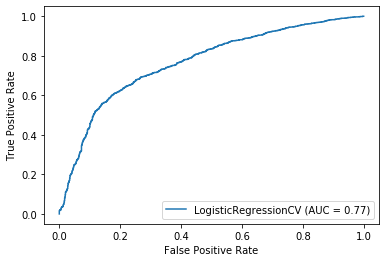

In [16]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, X_train, y_train)

## Evaluate the CV Performance of the Model

In [17]:
from sklearn.model_selection import cross_validate

model = LogisticRegressionCV()
cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=['accuracy', 'f1_macro', 'roc_auc'])
print(f'Accuracy: {np.mean(cv_results["test_accuracy"])}')
print(f'AUC: {np.mean(cv_results["test_roc_auc"])}')
print(f'Macro F1: {np.mean(cv_results["test_f1_macro"])}')

Accuracy: 0.7545814953059609
AUC: 0.7567641472064508
Macro F1: 0.5925332201513649


## Predict on the test data (S19)

In [18]:
early_test = pd.read_csv(os.path.join(TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(TEST_PATH, 'late.csv'))
X_test = extract_features(late_test, early_test, scaler, False)

In [19]:
X_test.shape

(1511, 25)

When writing output to be judged, make _sure_ to **output probabilities** for the positive class, so that we can calculate AUC when judging!

In [20]:
model = LogisticRegressionCV()
model.fit(X_train, y_train)
# Note the use of predict_proba (the [:,1] gets the positive probabilities)
predictions = model.predict_proba(X_test)[:,1]

In [21]:
predictions

array([0.71870299, 0.63676216, 0.80529838, ..., 0.7270374 , 0.70659839,
       0.69141046])

In [22]:
predictions_df = late_test.copy()
predictions_df['Label'] = predictions
predictions_df

,SubjectID,AssignmentID,ProblemID,Label
0,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,41,0.718703
1,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,43,0.636762
2,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,44,0.805298
3,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,46,0.618494
4,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,49,0.663353
...,...,...,...,...
1506,fc5f86251458722c799d1830fa0c2c1f,494.0,67,0.756331
1507,fc5f86251458722c799d1830fa0c2c1f,494.0,104,0.765930
1508,fc5f86251458722c799d1830fa0c2c1f,494.0,106,0.727037
1509,fc5f86251458722c799d1830fa0c2c1f,494.0,107,0.706598


In [23]:
# We don't have the test labels - you have to submit to evaluate it

In [24]:
# We use res/predictions.csv, since that's where the scoring rogram expects it
# but you can change this directory
path = os.path.join('data', 'Prediction', semester, 'basic_LR_task1', 'res')
os.makedirs(path, exist_ok=True)
predictions_df.to_csv(os.path.join(path, 'predictions.csv'), index=False)

## Predict on the test data for the _next_ semester (F19)

Here we see if our model will still be useful next semester. Again, we don't have labels for this test dataset, so we'll have to submit to see how well we did.

Later in the year, there will be _training_ data released for F19, which will be tested on a different track (not cross-semester).

In [25]:
F19_TEST_PATH = os.path.join('data', 'Release', 'F19', 'Test')

In [26]:
early_test = pd.read_csv(os.path.join(F19_TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(F19_TEST_PATH, 'late.csv'))
X_test = extract_features(late_test, early_test, scaler, False)

In [27]:
X_test.shape

(2365, 25)

In [28]:
model = LogisticRegressionCV()
model.fit(X_train, y_train)
predictions = model.predict_proba(X_test)[:,1]

In [29]:
predictions

array([0.81344772, 0.74948573, 0.87591233, ..., 0.40992631, 0.37947527,
       0.35654374])

In [30]:
predictions_df = late_test.copy()
predictions_df['Label'] = predictions
predictions_df

,SubjectID,AssignmentID,ProblemID,Label
0,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,41,0.813448
1,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,43,0.749486
2,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,44,0.875912
3,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,46,0.734523
4,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,49,0.770795
...,...,...,...,...
2360,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,64,0.432782
2361,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,70,0.256144
2362,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,71,0.409926
2363,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,112,0.379475


In [31]:
# We don't have the test labels - you have to submit to evaluate it

In [32]:
path = os.path.join('data', 'Prediction', 'F19', 'basic_LR_task1', 'res')
os.makedirs(path, exist_ok=True)
predictions_df.to_csv(os.path.join(path, 'predictions.csv'), index=False)

# Task 2

In this task, we are predicting final performance, extracting features from performance on the 30 early problems for a given student to predict the final exam grade.

In [33]:
train_base = train_ps2.load_link_table('Subject')
train_base

,SubjectID,X-Grade
0,65be44ae7088566069cc3bef454174a7,0.3600
1,f4db8537e9d75da46c4efc36a2d70956,0.4310
2,e3edca0f6e68bfb76eaf26a8eb6dd94b,0.8400
3,d843407a1a701630bb297c1148229eff,0.4900
4,d0a17b281c3e4eaef6718d891e38cb42,0.3400
...,...,...
242,4a914e5c38172ae9b61780ffbd0b2f90,0.8244
243,ffb72475a81de0e95b910ffad039f5c2,0.6817
244,40195594f1244e7ec627b1c6a5a35585,0.7029
245,e2d083a5fd066b082d93042169313e21,0.6800


In [34]:
train_base = late_train.groupby('SubjectID')['Label'].sum().to_frame('X-Grade').reset_index()
train_base['X-Grade'] = train_base['X-Grade'] / 20
train_base

,SubjectID,X-Grade
0,04c32d4d95425f73b3a1d6502aed4d48,0.55
1,0503bf609757acf2e75aa8cbc0d8323b,0.45
2,06d801cb636235b298c40029ad9921e7,0.90
3,07ae4cca3f90a49347ccb5c1a82ff46f,0.95
4,07d34e2419c61216a85a2156b2cf8ae4,0.75
...,...,...
241,f827b5406c7aa5b4fe10062ae06a137b,0.80
242,f892447540d0e840049183faa3109b1b,0.90
243,fda6baab618b39821b678bd52ff26428,0.15
244,feae21bb32b7b4aa690fab151b60b598,1.00


In [35]:
y_train = train_base['X-Grade']

In [36]:
# The base of our X dataset is just a set of SubjectIDs
X_train_base = train_base.drop('X-Grade', axis=1)

In [37]:
from sklearn.preprocessing import StandardScaler
X_train_unscaled = X_train_base.apply(lambda row: extract_instance_features(row, early_train), axis=1)

In [38]:
X_train_unscaled

,ProblemsAttempted,PercCorrectEventually,MedAttempts,MaxAttempts,PercCorrectFirstTry
0,30,1.000000,6.5,45,0.166667
1,21,1.000000,2.0,11,0.476190
2,20,1.000000,2.0,31,0.350000
3,30,0.966667,1.0,21,0.733333
4,30,1.000000,1.0,12,0.600000
...,...,...,...,...,...
241,30,1.000000,1.0,7,0.533333
242,30,0.966667,1.0,14,0.666667
243,29,0.655172,4.0,22,0.172414
244,30,0.966667,1.0,9,0.933333


In [39]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_train

array([[ 0.55944356,  0.60104733,  1.73417818,  1.78407068, -0.88773091],
       [-1.11888712,  0.60104733, -0.48645253, -0.62386335,  0.39482508],
       [-1.30536831,  0.60104733, -0.48645253,  0.79256843, -0.12806313],
       ...,
       [ 0.37296237, -2.04668342,  0.50049446,  0.15517413, -0.86391688],
       [ 0.55944356,  0.34510002, -0.97992602, -0.76550653,  2.28906163],
       [-1.30536831,  0.60104733, -0.48645253,  0.58010367,  0.07911899]])

In [40]:
X_train_unscaled.join(train_base).drop(PS2.SubjectID, axis=1).corr()

,ProblemsAttempted,PercCorrectEventually,MedAttempts,MaxAttempts,PercCorrectFirstTry,X-Grade
ProblemsAttempted,1.000000,0.284741,-0.196953,0.131532,0.135139,0.318915
PercCorrectEventually,0.284741,1.000000,-0.343506,-0.069976,0.337193,0.432099
MedAttempts,-0.196953,-0.343506,1.000000,0.669611,-0.781536,-0.458429
MaxAttempts,0.131532,-0.069976,0.669611,1.000000,-0.574600,-0.259660
PercCorrectFirstTry,0.135139,0.337193,-0.781536,-0.574600,1.000000,0.451771
X-Grade,0.318915,0.432099,-0.458429,-0.259660,0.451771,1.000000


## Evaluate the Training Performance of the Model

In [41]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression

model = LassoCV()
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)

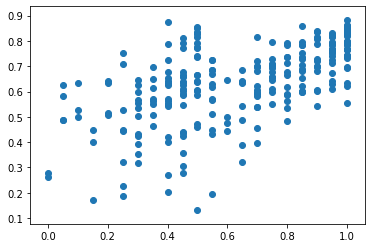

In [42]:
plt.scatter(y_train, train_predictions)

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('Training MSE: ' + str(mean_squared_error(y_train, train_predictions)))
print('Training R2: ' + str(r2_score(y_train, train_predictions)))

Training MSE: 0.048443143030792175
Training R2: 0.3419949456061411


## Evaluate the CV Performance of the Model

The naive model performs quite poorly evaluated by CV on the training data (R2 of 0.083). Can you improve on it?

In [44]:
from sklearn.model_selection import cross_validate

model = LassoCV()
cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=['neg_mean_squared_error', 'r2'])
print(f'MSE: {-np.mean(cv_results["test_neg_mean_squared_error"])}')
print(f'R2: {np.mean(cv_results["test_r2"])}')

MSE: 0.050437248898341905
R2: 0.2792971411405756


## Predict on the test data (S19)

In [47]:
test_ps2 = ProgSnap2Dataset(os.path.join(TEST_PATH, 'Data'))
early_test = pd.read_csv(os.path.join(TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(TEST_PATH, 'late.csv'))

# The Subject.csv link table is just the SubjectIDs to be predicted
X_test_base = test_ps2.load_link_table('Subject')
X_test_unscaled = X_test_base.apply(lambda row: extract_instance_features(row, early_test), axis=1)
X_test_unscaled

,ProblemsAttempted,PercCorrectEventually,MedAttempts,MaxAttempts,PercCorrectFirstTry
0,19,0.421053,4.0,35,0.210526
1,19,0.789474,5.0,41,0.157895
2,24,0.916667,2.5,29,0.291667
3,17,0.764706,2.0,77,0.352941
4,30,1.000000,3.0,41,0.300000
...,...,...,...,...,...
78,30,0.966667,3.0,44,0.300000
79,30,1.000000,1.0,4,0.766667
80,20,1.000000,1.0,10,0.650000
81,20,1.000000,1.0,4,0.650000


In [48]:
X_test = scaler.transform(X_test_unscaled)

In [49]:
X_test.shape

(83, 5)

When writing output to be judged, make _sure_ to **output probabilities** for the positive class, so that we can calculate AUC when judging!

In [50]:
model = LassoCV()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [51]:
predictions

array([ 2.25210773e-01,  3.81428547e-01,  5.82786728e-01,  4.10956312e-01,
        6.64174706e-01,  6.15620613e-01,  5.91372031e-01,  7.81499333e-01,
        6.14208739e-01,  7.42456756e-01, -1.00441829e-01,  7.06688698e-01,
        8.25546781e-01,  4.65928547e-01,  7.64090294e-01,  6.76188458e-01,
        7.49631140e-01,  7.81860473e-01,  7.24074988e-01,  6.16245391e-01,
        7.78524312e-01,  6.08201863e-01, -3.48426295e-01,  8.38756458e-01,
        5.50283756e-01,  7.27688089e-01,  7.74100420e-04,  5.60165847e-01,
        6.32946519e-01,  5.90343327e-01,  8.22904483e-01,  5.10591476e-01,
        7.30022913e-01,  4.29984394e-01,  8.00882247e-01,  6.80623584e-01,
        5.89676162e-01,  5.31832586e-01,  6.39217575e-01,  6.25798903e-01,
        6.27982633e-01,  6.81292007e-01,  5.55844944e-01,  6.54567488e-01,
        6.81596314e-01,  6.91398778e-01,  7.90704426e-01,  7.24103405e-01,
        8.27577490e-01,  3.62362656e-01,  6.16329162e-01,  6.62812420e-01,
        7.36447372e-01,  

In [55]:
predictions_df = X_test_base.copy()
predictions_df['X-Grade'] = predictions
predictions_df

,SubjectID,X-Grade
0,0bdf2c1f053650715e1f0c725d754b96,0.225211
1,d7419ae04f248e5105ac3d0700389775,0.381429
2,81a0c4689fb7ce553a0d5c2fd19b6efd,0.582787
3,468cbac056133a996283cca7e2976336,0.410956
4,e4191d610537305de1d294adb121b513,0.664175
...,...,...
78,cb03474483e366b5c8dd9f4a2a7537c1,0.643791
79,cc70903297fe1e25537ae50aea186306,0.838756
80,29b2cd4a11745fefecc14912d2f95dd8,0.711921
81,700fe688ff2970d633ff04c9b7f7cdd4,0.717928


In [53]:
# We don't have the test labels - you have to submit to evaluate it

In [56]:
# We use res/predictions.csv, since that's where the scoring rogram expects it
# but you can change this directory
path = os.path.join('data', 'Prediction', semester, 'basic_LR_task2', 'res')
os.makedirs(path, exist_ok=True)
predictions_df.to_csv(os.path.join(path, 'predictions.csv'), index=False)